In [2]:
import gensim.downloader as api

wv = api.load("word2vec-google-news-300")


In [3]:
wv.similarity(w1='great',w2='good')

0.729151

In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv("fake_and_real_news.csv")

df.shape

(9900, 2)

In [6]:
df.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [7]:
df.label.value_counts()

Fake    5000
Real    4900
Name: label, dtype: int64

In [8]:
df["label_num"] = df.label.map({
    "Fake":0,
    "Real":1
})
df.head()

,Text,label,label_num
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0
1,U.S. conservative leader optimistic of common ...,Real,1
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0
4,Democrats say Trump agrees to work on immigrat...,Real,1


In [16]:
import spacy
nlp = spacy.load("en_core_web_lg")

def preprocess_and_vectorize(text):
    doc = nlp(text)
    
    filtered_tokens = []
    for token in doc:
        if token.is_punct or token.is_stop:
            continue
        filtered_tokens.append(token.lemma_)
    return wv.get_mean_vector(filtered_tokens)

In [17]:
preprocess_and_vectorize("don't worry if you don't understand")

array([ 0.00235079, -0.00284596, -0.03638233,  0.00413919, -0.10635224,
        0.05758579,  0.13348952, -0.00689176,  0.05995331, -0.02875906,
       -0.02279907, -0.06939262, -0.01549996,  0.03538099, -0.0873947 ,
        0.10044542,  0.02490648,  0.11501945,  0.00442711, -0.07228819,
       -0.04447255,  0.02785169,  0.03338735,  0.02222995,  0.07053161,
        0.06723307,  0.03483712, -0.0873695 ,  0.04152397, -0.0969665 ,
       -0.00914938,  0.00555944, -0.0277799 , -0.00701522,  0.05281431,
       -0.01066206,  0.02466576,  0.02378148,  0.0279402 ,  0.05527755,
        0.01359304, -0.01062085,  0.06734448, -0.03492254, -0.08421434,
       -0.04324378, -0.03578918, -0.00817786, -0.02093195,  0.01856531,
       -0.07064191,  0.05023994, -0.03036207, -0.0412168 , -0.00684169,
        0.05189689, -0.04097777, -0.05789134,  0.044417  , -0.0470418 ,
       -0.01475445,  0.01373999, -0.00459672,  0.00419459,  0.04307397,
       -0.01500929, -0.08037488,  0.05358911, -0.0211829 , -0.00

In [18]:
wv.get_mean_vector(["worry","understand"],pre_normalize=False)[:3]

array([ 0.00976562, -0.00561523, -0.08905029], dtype=float32)

In [19]:
df['vector'] = df['Text'].apply(lambda text:preprocess_and_vectorize(text))

In [20]:
df.head()

,Text,label,label_num,vector
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0,"[0.008657642, 0.019024342, -0.011917442, 0.032..."
1,U.S. conservative leader optimistic of common ...,Real,1,"[0.010864096, 0.007960429, 0.0011915653, 0.014..."
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1,"[0.018134918, 0.0062743523, -0.005872244, 0.03..."
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0,"[0.01255197, 0.012613623, 5.9780963e-05, 0.021..."
4,Democrats say Trump agrees to work on immigrat...,Real,1,"[-0.0019059887, 0.011889367, 0.0035395357, 0.0..."


**Train-Test Split**

In [23]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(
    df.vector.values,
    df.label_num,
    test_size=0.2,
    random_state=2022,
    stratify=df.label_num
)


**Reshaping the X_train and X_test so as to fit for models**

In [24]:
print("Shape of X_train before reshaping:",X_train.shape)
print("Shape of X_test before reshaping:",X_test.shape)

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

print("Shape of X_train after reshaping:",X_train_2d.shape)
print("Shape of X_test after reshaping:",X_test_2d.shape)

Shape of X_train before reshaping: (7920,)
Shape of X_test before reshaping: (1980,)
Shape of X_train after reshaping: (7920, 300)
Shape of X_test after reshaping: (1980, 300)


**Train Machine Learning Model**

I tried Random forest, decision tree, Naive bayes etc classifiers as well but gradient boosting gave the best result


In [26]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

#1. Creating a GradientBoosting model object
clf = GradientBoostingClassifier()

#2. Fit with all_train_embedding and y_train
clf.fit(X_train_2d,y_train)

#3. Get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)

#4. Print the classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1000
           1       0.97      0.99      0.98       980

    accuracy                           0.98      1980
   macro avg       0.98      0.98      0.98      1980
weighted avg       0.98      0.98      0.98      1980



**Make some Predictions**

In [28]:
test_news=[
    "Michigan governor denies misleading U.S> House on Flint water(Reuters)",
    "Senators grill U.S. education secretary on proposal to slash budget WASHINGTON (Reuters) - U.S. Education Secretary Betsy DeVos faced hostile questions from a Senate committee on Tuesday as she tried to win lawmakers over to President Donald Trumpâ€™s proposal to slash her departmentâ€™s funding by 13 percent. DeVos, a Republican who narrowly won Senate approval for her post in February after strident opposition from Democrats and a few fellow party members, testified before the Senate appropriations subcommittee on education about the proposed budget Trump submitted to Congress last month. Trumpâ€™s plan to cut $9 billion from the Education Departmentâ€™s budget would â€œimprove educational opportunitiesâ€ and shift the federal role in education, DeVos told the panel. â€œI understand those figures are alarming for many,â€ she said. â€œHowever, this budget refocuses the department on supporting states and school districts in their efforts to provide high-quality education to all our students.â€ Democrats took turns asking DeVos about the bigger budget line-items and talking about students who they say could be hurt by large spending cuts. The most pointed exchanges were on whether private schools that receive federal funds would have to agree not to discriminate against students. DeVos would only repeat that schools taking federal money must abide by U.S. law. But Senator Jeff Merkley and his fellow Democrats said she was refusing to answer the question because federal law is unclear in many areas of possible discrimination, such as the rights of transgendered people. Lawmakers are expected to alter Trumpâ€™s proposed budget before voting on it.  The subcommitteeâ€™s chair, conservative Republican Roy Blunt, said he believed Congress would not approve the budget as proposed. â€œSuch a significant cut to the departmentâ€™s budget is likely untenable,â€ Blunt said, pressing specifically to preserve funds for technical programs, work-study financial aid and the Special Olympics. Civil rights groups and Democrats say the budget would send public dollars to private companies, disband after-school care, hurt schools in poor neighborhoods, shrink the ranks of teachers, and make it harder for many to afford college.  DeVos is currently working on major transformations in student loans. The budget suggests changing income-based repayment plans and ending loan forgiveness for workers in the public sector, which DeVos said would clear up confusion around the loans. With the stated aim of giving parents more choices for their childrenâ€™s education, DeVos and Republicans support charter schools, which are publicly funded but operate independently, frequently by corporations, as well as subsidies to help pay private-school tuition. Many Republicans on the panel applauded the budgetâ€™s proposal to boost such â€œschool choiceâ€ programs. But the subcommitteeâ€™s senior Democrat, Patty Murray, said the cuts â€œhighlight the ways that the policies and priorities you and President Trump are pushing would hurt students, hurt communities, and represent a clear broken promise to workers and the middle class.â€",
    
]
test_news_vectors = [preprocess_and_vectorize(n) for n in test_news]
clf.predict(test_news_vectors)

array([1, 1], dtype=int64)

**Confusion matrix for Best Model**




Text(95.72222222222221, 0.5, 'Truth')

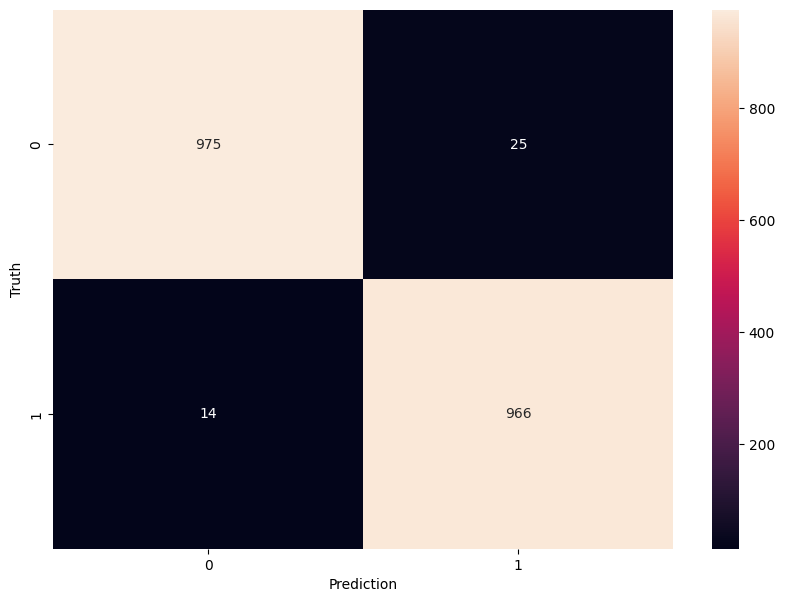

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')
